In [1]:
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF


/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check Band Structure

# initial rotate H or S func.


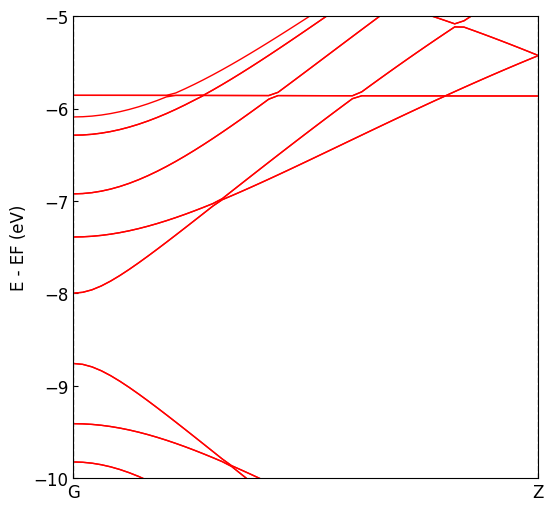

In [2]:
checkfile = './best_nnsk_c3.0w0.01.json'
#checkfile = "./inputSiGe.json"
nnskapi = NNSKHost(checkpoint=checkfile, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')
run_opt={"structure":"/data/DFT/CNT/CNT40/PRIMCELL.vasp",
        "results_path":"./"}
jdata={
        "kline_type":"abacus",
        "kpath":[[0.0000000000, 0.0000000000, 0.0000000000, 50],
                 [0.0000000000, 0.0000000000, 0.5000000000, 1]
                 ],
        "klabels":['G','Z'],
        "emin":-10,
        "emax":10
        }
bcalc = bandcalc(apiHrk=nnHrk,run_opt=run_opt,jdata=jdata)
eigenstatus = bcalc.get_bands()

band = np.loadtxt('./BANDS_1.dat')

plt.figure(figsize=(6,6),dpi=100)
#plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'] - eigenstatus['E_fermi'], 'r-',lw=1)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'], 'r-',lw=1)
# plt.plot(band['xcoords'],band['eigenvalues']-np.min(band['eigenvalues']),'k--',ms=2)
# plt.plot(eigenstatus['xlist'], band[:,2:] - np.min(band[:,2:]),'k--',lw=1)
plt.ylim(-10,-5)


for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
#plt.ylim(emin,emax)

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
# plt.axhline(40.0)
plt.show()

# Compute Transmission

In [1]:
jdata = {
        "task": "negf",
        "scf": True,
        "ele_T": 500,
        "unit": "Hartree",
        "read_HS":True,
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            },
            "d_trains":"z"
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [4]:
!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

run_opt={"structure":atom,
        "results_path":"./"}


negf = NEGF(apiHrk=nnHrk, run_opt=run_opt, jdata=jdata)

# initial rotate H or S func.


In [5]:
negf.compute_electrode_self_energy()

True

In [6]:
negf.compute_green_function()

True

In [7]:
gtrains = [i[0] for i in negf.green]

TT = []
for i in range(120):
    TT.append(negf.calTT(
        seL=negf.SeE["lead_L"][i],
        seR=negf.SeE["lead_R"][i],
        gtrains=gtrains[i]
    ).data)

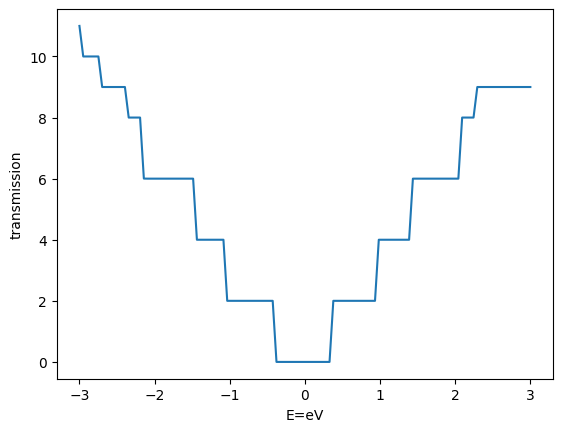

In [8]:

plt.plot(torch.linspace(-3,3,120), TT)
plt.xlabel("E=eV")
plt.ylabel("transmission")
plt.show()

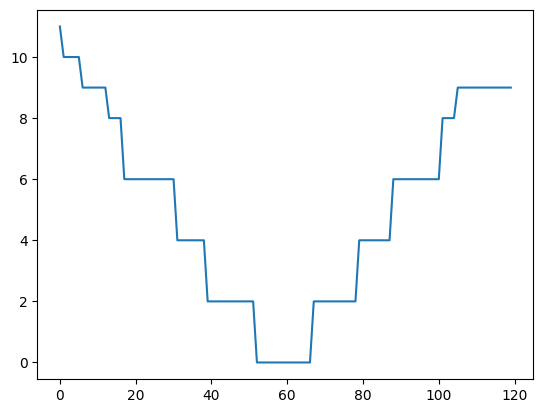

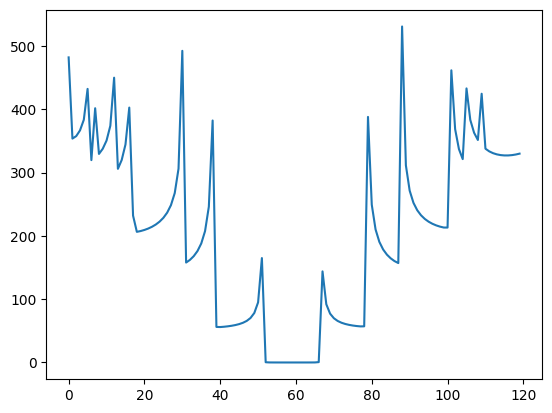

In [6]:
import torch

f=  torch.load("calc/results/properties.pth")
TC = torch.tensor(f["TC"])
import matplotlib.pyplot as plt

plt.plot(TC)
plt.show()

DOS = torch.tensor(f["DOS"])

plt.plot(DOS)
plt.show()

In [1]:
jdata = {
        "task": "negf",
        "scf": True,
        "ele_T": 500,
        "unit": "Hartree",
        "read_HS":True,
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            },
            "d_trains":"z"
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [2]:
from dptb.negf.hamiltonian import Hamiltonian
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF

!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

h = Hamiltonian(apiH=nnHrk, structase=atom, stru_options=jdata["stru_options"], result_path="./refactor")

struct_device, struct_leads = h.initialize(kpoints=[[0,0,0]])

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# initial rotate H or S func.


In [3]:
from dptb.negf.Device import Device
from dptb.negf.Lead import Lead

# device = Device(h, struct_device)
# device.set_leadLR(
#     lead_L=Lead(h, tab="lead_L", structure=struct_leads["lead_L"]),
#     lead_R=Lead(self.hamiltonian, tab="lead_R", structure=struct_leads["lead_L"])
#     )
lead_L = Lead(tab="lead_L", hamiltonian=h, structure=struct_leads["lead_L"], result_path="./refactor/")

lead_L.self_energy(kpoint=[0,0,0], ee=[0,0.5,1])


In [16]:
lead_L.self_energy(kpoint=[0,0,0], ee=[0,0.5,1.000001, 1.5001])

In [17]:
f = torch.load("./refactor/lead_L_SE_k0.pth")

In [18]:
len(f["se"])

5